In [158]:

import mne 
from mne import create_info
from mne.io import RawArray

import numpy as np
import pandas as pd
import pywt

In [159]:
mne.set_config('MNE_BROWSE_RAW_SIZE','10,5')

In [160]:
df = pd.read_csv("C:/Users/Aaroosh/OneDrive/Desktop/CODE/EEG/AAROOSH_test17INSANE.csv")


df.head()

,1-31,CP3,C3,F5,PO3,PO4,F6,C4,CP4,Marker
0,0.0,-55262.355469,-90680.992188,-265571.56250,5589.455566,-30005.603516,17863.914062,-68114.835938,-66681.187500,0
1,1.0,-55457.218750,-90052.890625,-263598.90625,5483.709473,-31734.958984,19545.189453,-68211.796875,-66671.335938,0
2,3.0,-55375.343750,-97257.570312,-271477.09375,5630.694336,-31934.246094,11362.105469,-74824.515625,-66632.375000,0
3,4.0,-55236.339844,-92025.179688,-267075.53125,5614.735352,-30082.917969,16352.355469,-69344.156250,-66672.609375,0
4,5.0,-55387.214844,-89319.304688,-263295.62500,5500.875488,-31133.205078,20022.890625,-67332.429688,-66676.367188,0


In [161]:
df = df.drop(df.columns[0], axis=1)
df.head()
df.columns = ["CP3", "C3", "F5", "PO3", "PO4", "F6", "C4", "CP4", "Marker"]
print(df['Marker'].unique())

[0 1 2]


In [162]:
def df_to_raw(df):
    sfreq = 256  #our Neurosity headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T 
    df[:-1] *= 1e-6  #convert from uVolts to Volts 

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #plotting power spectral density
    raw.compute_psd().plot()

    return raw
raw = df_to_raw(df)

Creating RawArray with float64 data, n_channels=9, n_times=146682
    Range : 0 ... 146681 =      0.000 ...   572.973 secs
Ready.
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


C:\Users\Aaroosh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

C:\Users\Aaroosh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


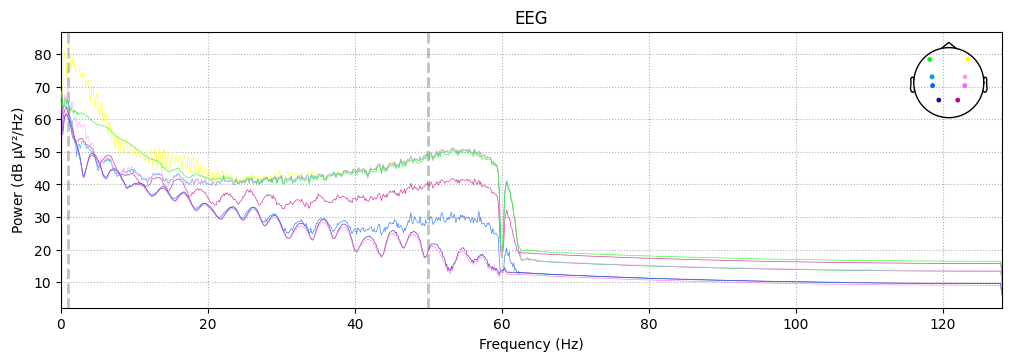

In [163]:
raw.filter(1, 50)
raw.notch_filter(60)
raw.compute_psd().plot()

In [164]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [165]:
event_id = {'Non-Target': 1, 'Target' : 2}
tmin = -0.1
tmax = 0.6
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks)

721 events found on stim channel Marker
Event IDs: [1 2]
sample drop %:  0.0


In [166]:
epochs_non_target = epochs['Non-Target']
epochs_target = epochs['Target']

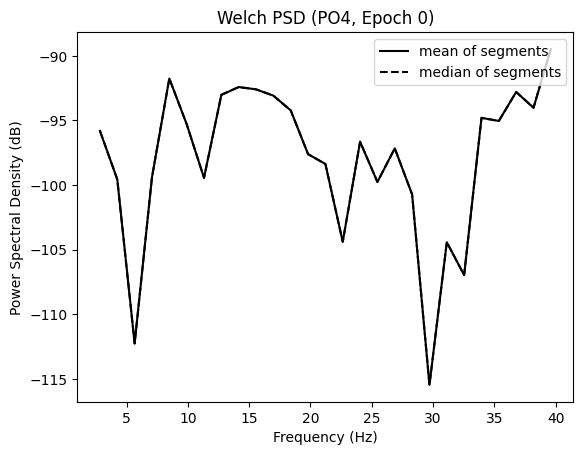

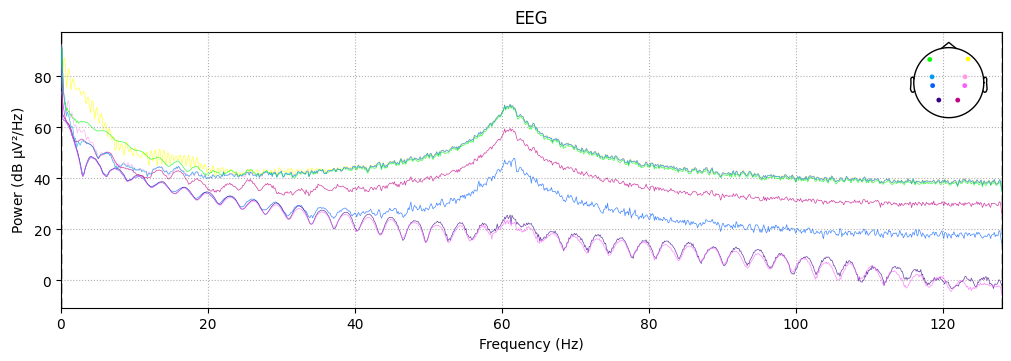

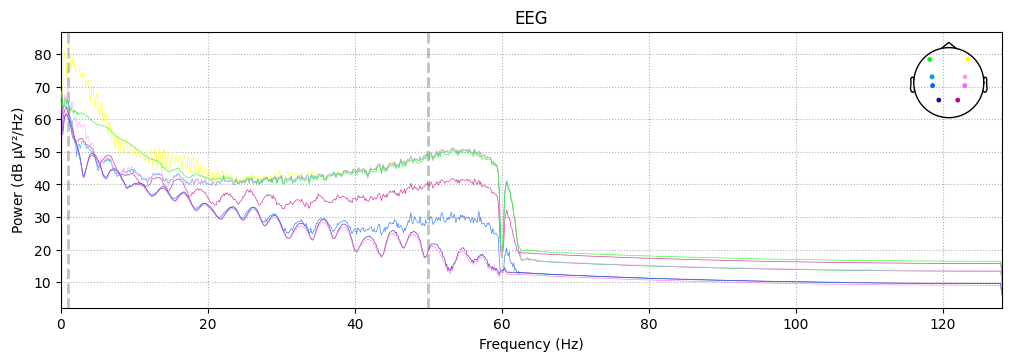

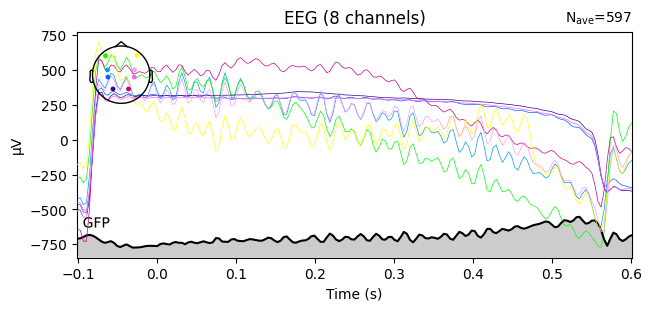

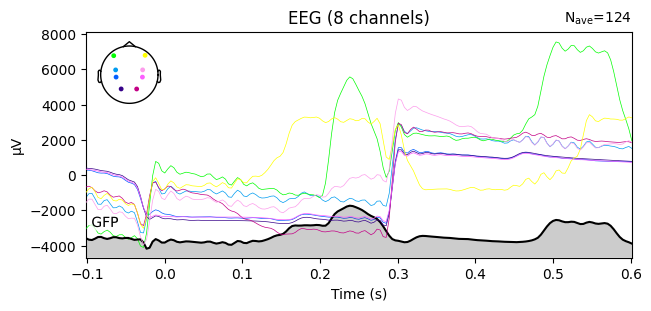

In [167]:
evoked_non = epochs['Non-Target'].average()
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s');
evoked_target = epochs['Target'].average()
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s');

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


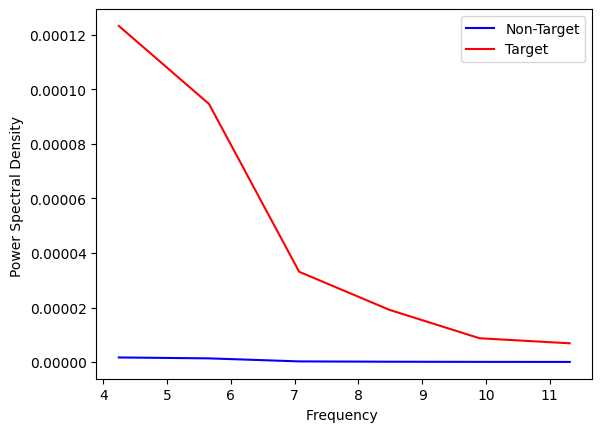

In [168]:
import matplotlib.pyplot as plt
import mne

fmin, fmax = 4, 12


psds_non = evoked_non.compute_psd(fmin=fmin, fmax=fmax).get_data()
freqs_non = evoked_non.compute_psd(fmin=fmin, fmax=fmax).freqs
psds_target = evoked_target.compute_psd(fmin=fmin, fmax=fmax).get_data()
freqs_target = evoked_target.compute_psd(fmin=fmin, fmax=fmax).freqs


plt.figure()
plt.plot(freqs_non, psds_non.mean(axis=0), label='Non-Target', color='blue')
plt.plot(freqs_target, psds_target.mean(axis=0), label='Target', color='red')
plt.xlabel('Frequency ')
plt.ylabel('Power Spectral Density ')

plt.legend()
plt.show()


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: mean)


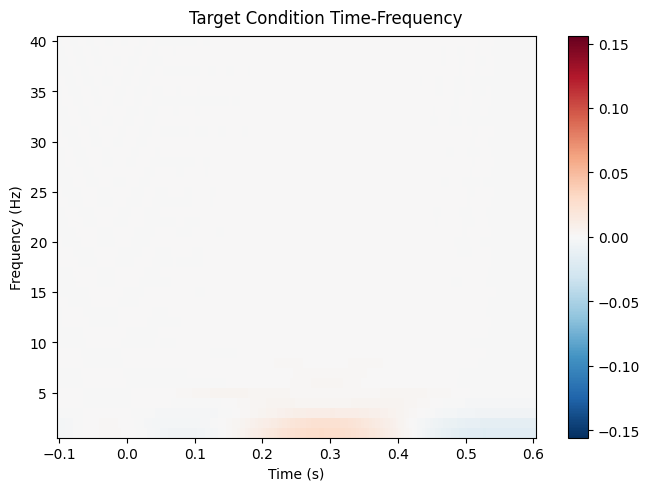

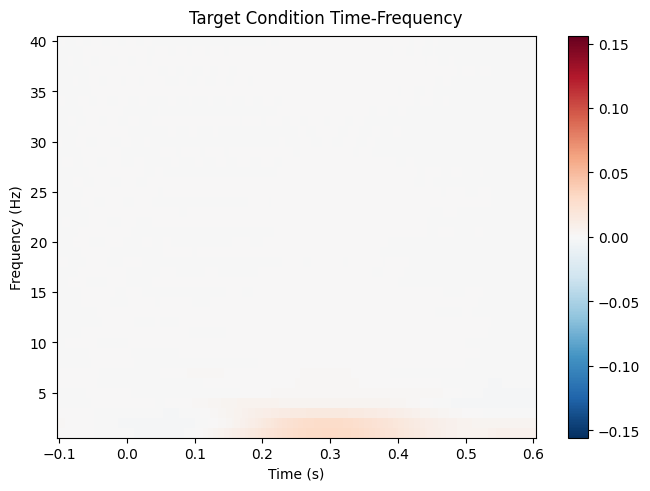

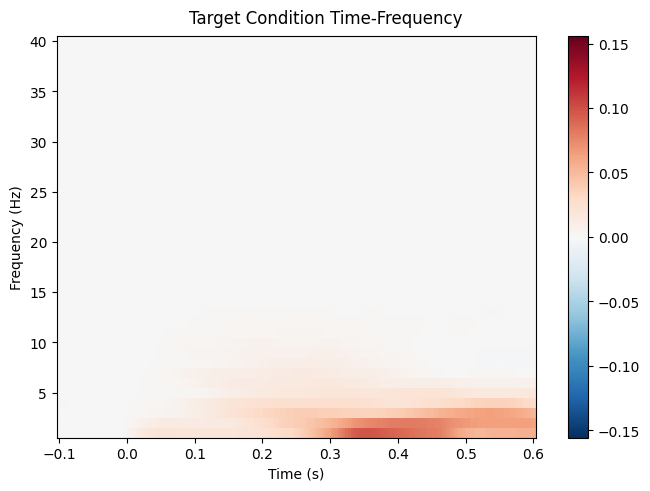

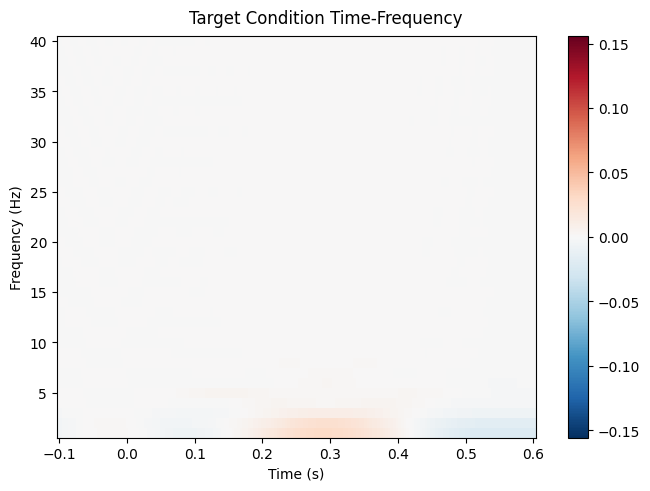

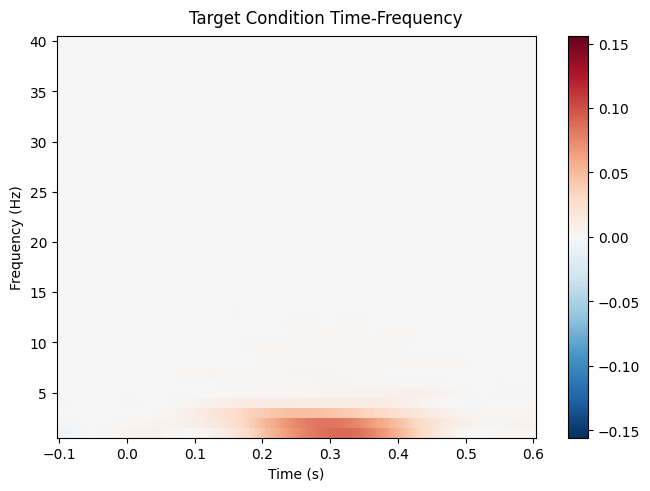

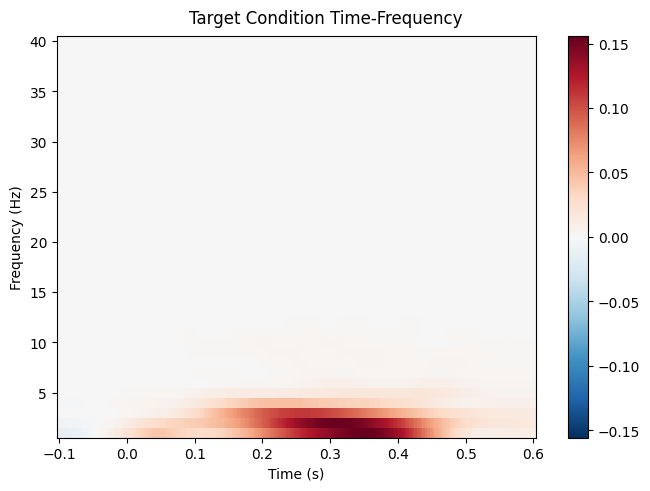

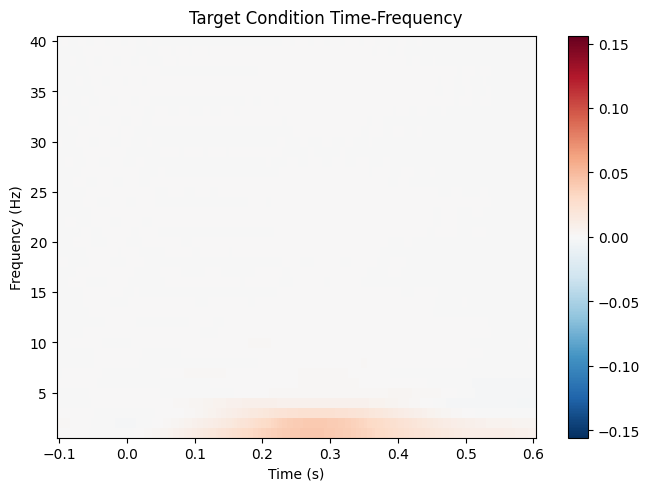

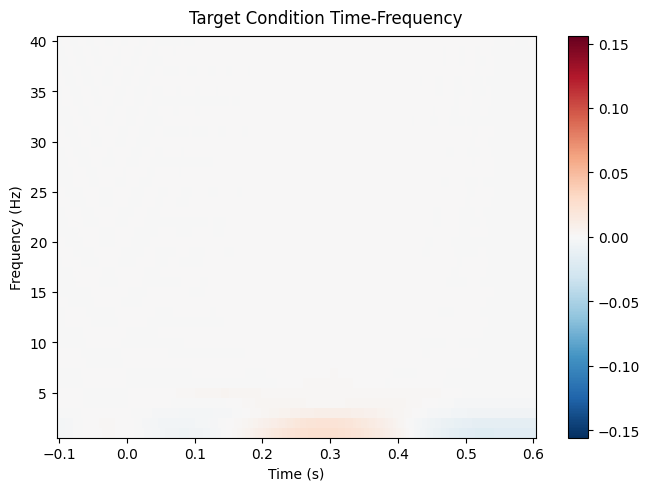

Applying baseline correction (mode: mean)


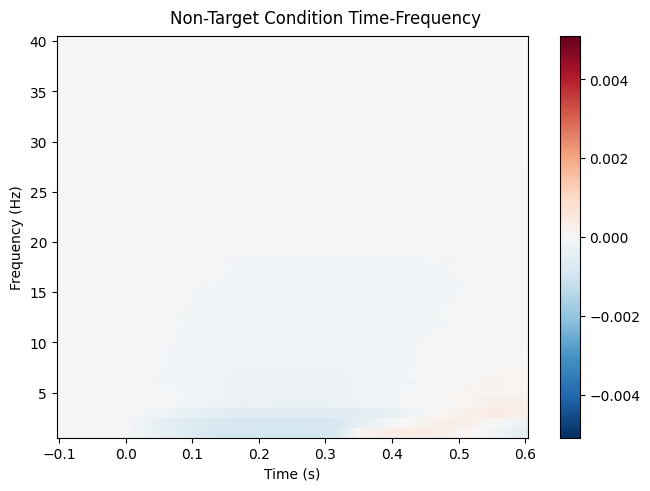

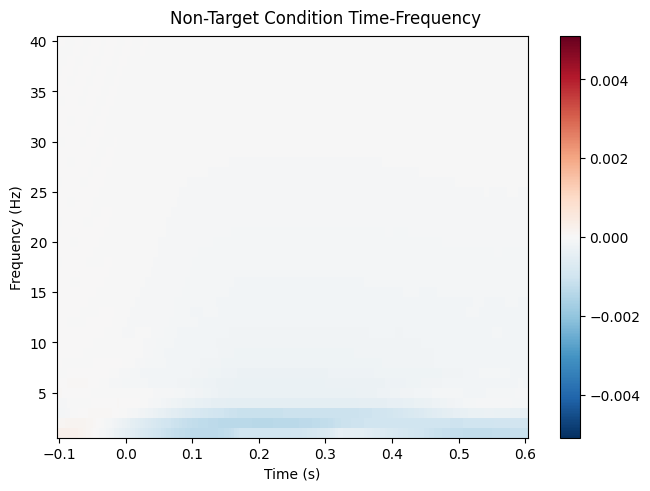

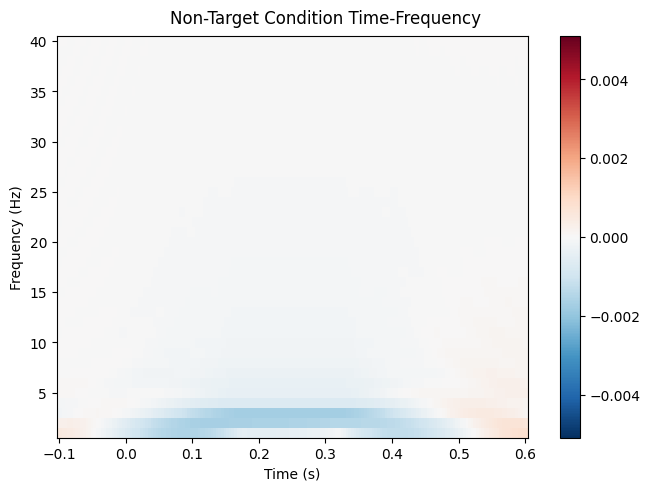

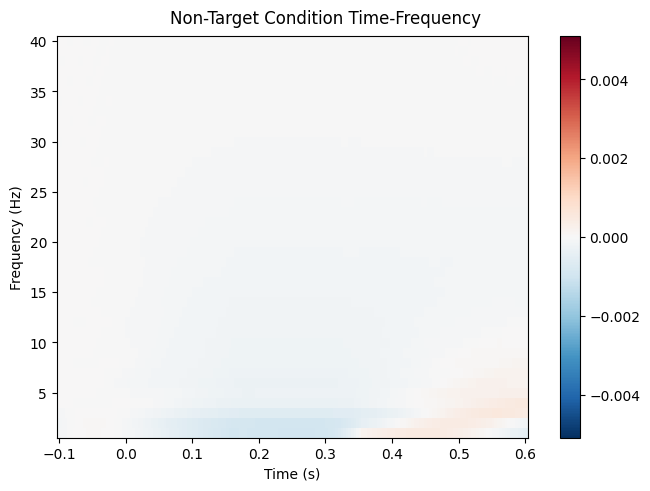

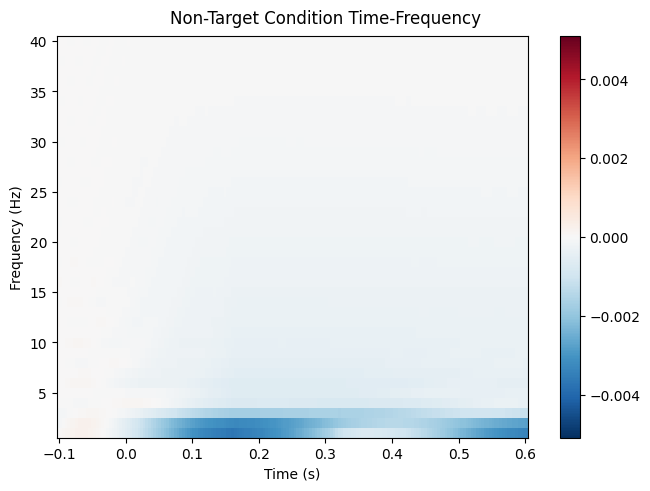

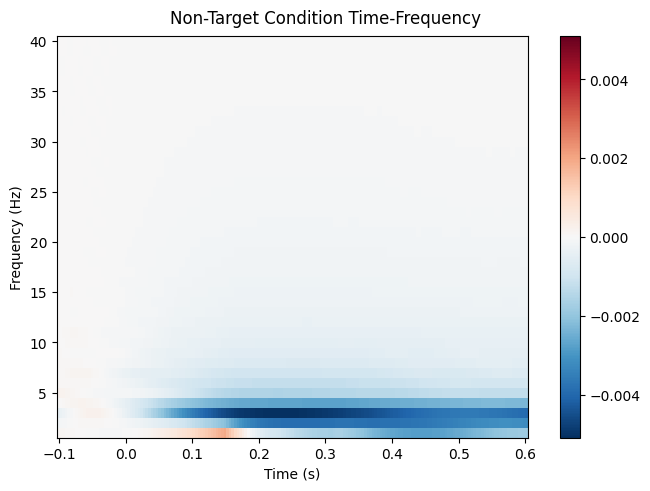

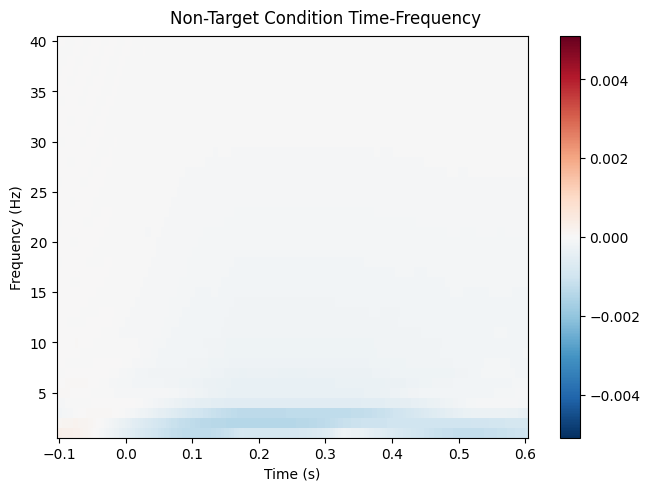

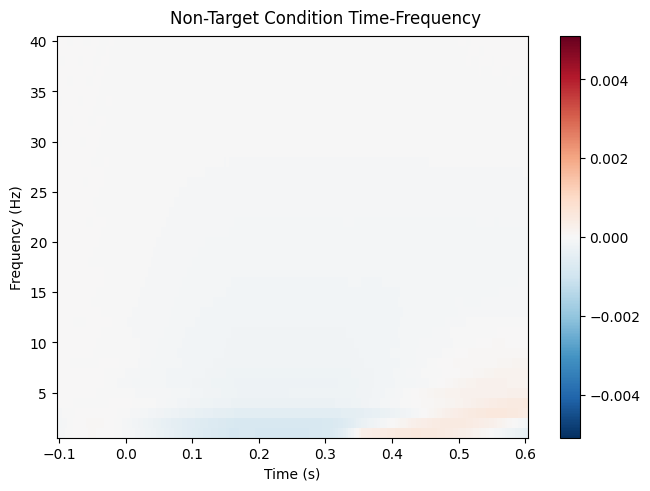

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

In [169]:
from mne.time_frequency import tfr_multitaper
freqs = np.linspace(1, 40, 40)  
n_cycles = freqs / 2  #just needed to work
power_non = tfr_multitaper(epochs['Non-Target'], freqs=freqs, n_cycles=n_cycles, time_bandwidth=2.0, return_itc=False)
power_target = tfr_multitaper(epochs['Target'], freqs=freqs, n_cycles=n_cycles, time_bandwidth=2.0, return_itc=False)
power_target.plot(baseline=(None, 0), mode='mean', title='Target Condition Time-Frequency')
power_non.plot(baseline=(None, 0), mode='mean', title='Non-Target Condition Time-Frequency')

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


C:\Users\Aaroosh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


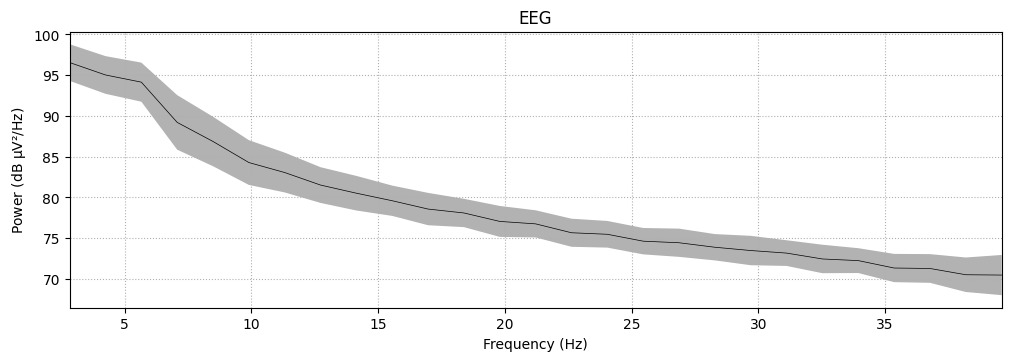

In [170]:
epochs.compute_psd(fmin=2.0, fmax=40.0).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


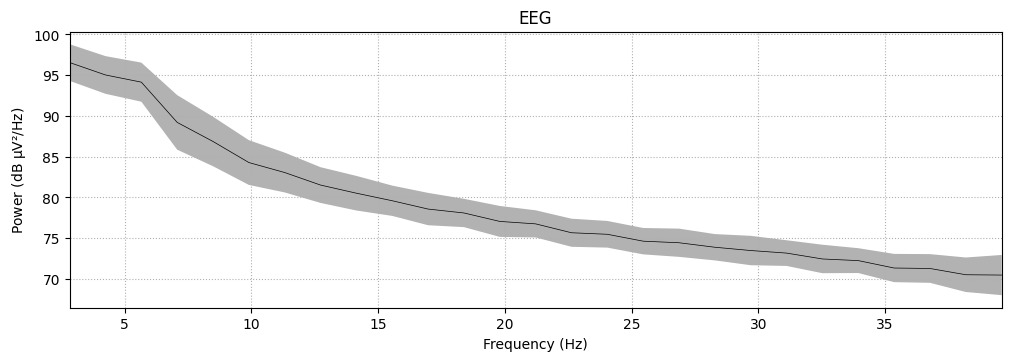

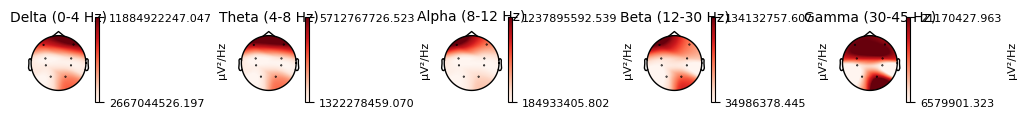

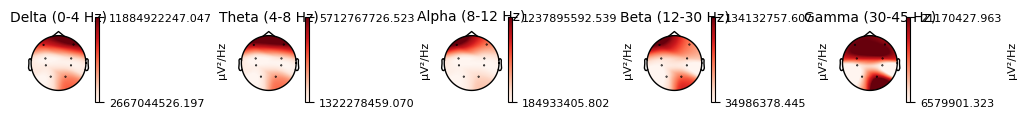

In [171]:
epochs.compute_psd().plot_topomap(ch_type="eeg", normalize=False, contours=0)

In [183]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=None)
psds_welch_mean, freqs_mean = epochs.compute_psd(
    "welch", average="mean", **kwargs
).get_data(return_freqs=True)
psds_welch_median, freqs_median = epochs.compute_psd(
    "welch", average="median", **kwargs
).get_data(return_freqs=True)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = "PO4"
ch_idx = epochs.info["ch_names"].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(
    freqs_mean,
    psds_welch_mean[epo_idx, ch_idx, :],
    color="k",
    ls="-",
    label="mean of segments",
)
ax.plot(
    freqs_median,
    psds_welch_median[epo_idx, ch_idx, :],
    color="k",
    ls="--",
    label="median of segments",
)

ax.set(
    title=f"Welch PSD ({ch_name}, Epoch {epo_idx})",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)



Effective window size : 0.707 (s)
Effective window size : 0.707 (s)


<function matplotlib.pyplot.show(close=None, block=None)>

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


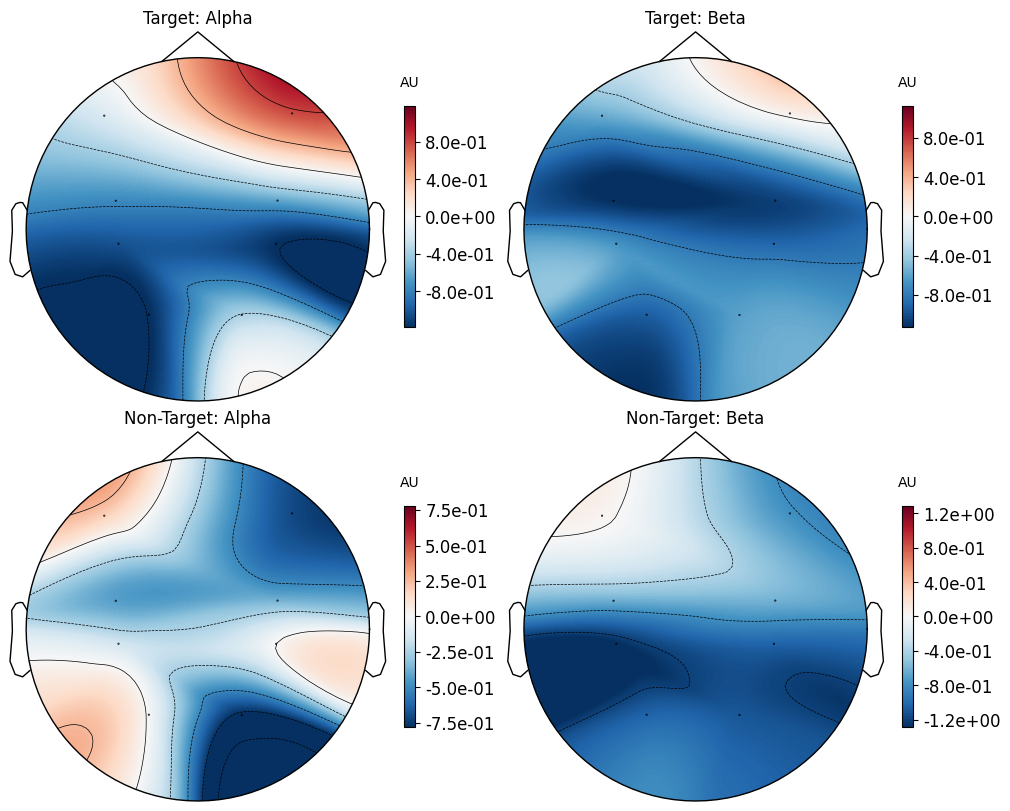

Applying baseline correction (mode: logratio)


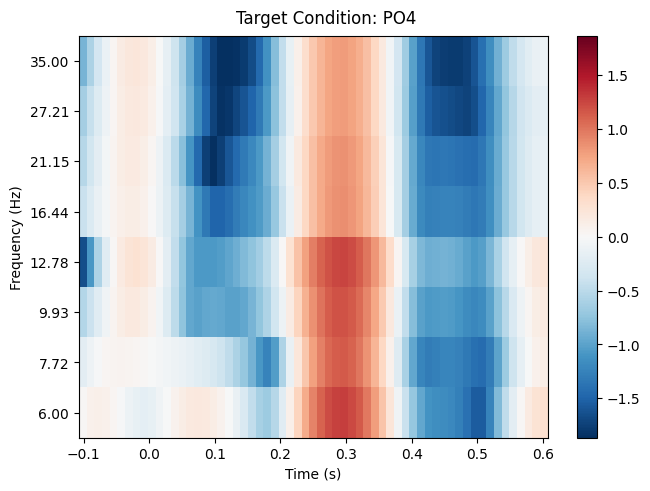

Applying baseline correction (mode: logratio)


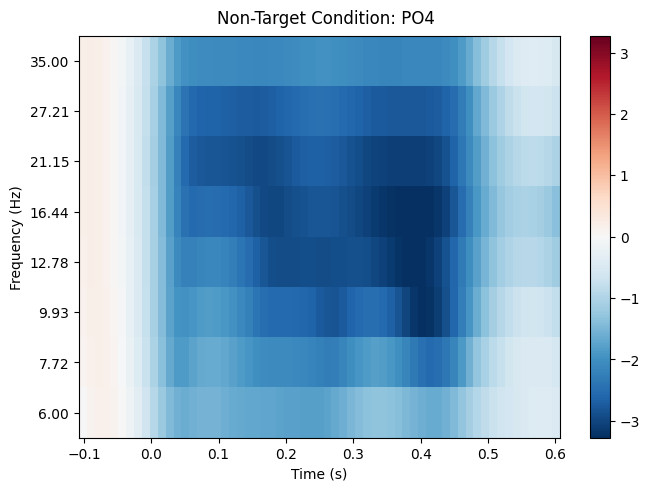

[<Figure size 640x480 with 2 Axes>]

In [194]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Define frequencies of interest
freqs = np.logspace(*np.log10([6, 35]), num=8)  # Adjust frequency range as needed
n_cycles = freqs / 3.0  # Different number of cycles per frequency

# Compute TFR for the target condition
power_target, itc_target = mne.time_frequency.tfr_morlet(
    epochs['Target'], freqs=freqs, n_cycles=n_cycles, return_itc=True, decim=3, average=True
)

# Compute TFR for the non-target condition
power_non_target, itc_non_target = mne.time_frequency.tfr_morlet(
    epochs['Non-Target'], freqs=freqs, n_cycles=n_cycles, return_itc=True, decim=3, average=True
)

# Plot topographies for comparison
fig, axes = plt.subplots(2, 2, figsize=(10, 8), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=0.5, tmax=1.5, baseline=(-0.5, 0), mode="logratio", show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))

# Plot topomaps for the target condition
for ax, (title, fmin_fmax) in zip(axes[0, :], plot_dict.items()):
    power_target.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(f"Target: {title}")

# Plot topomaps for the non-target condition
for ax, (title, fmin_fmax) in zip(axes[1, :], plot_dict.items()):
    power_non_target.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(f"Non-Target: {title}")

plt.show()

# Plot power for a specific channel for both conditions for comparison
channel_idx = 4  # Replace with your desired channel index
power_target.plot(picks=[channel_idx], baseline=(-0.5, 0), mode="logratio", title=f"Target Condition: {power_target.ch_names[channel_idx]}")
power_non_target.plot(picks=[channel_idx], baseline=(-0.5, 0), mode="logratio", title=f"Non-Target Condition: {power_non_target.ch_names[channel_idx]}")


In [173]:
# data_non_target = epochs_non_target.get_data()  # Shape: (n_epochs, n_channels, n_times)
# data_target = epochs_target.get_data()  # Shape: (n_epochs, n_channels, n_times)

# # Wavelet transform parameters
# wavelet = 'db4'  # Daubechies wavelet
# level = 4  # Level of decomposition

# # Function to perform wavelet transform on each epoch
# def wavelet_transform_group(data_group):
#     coeffs_group = []
#     for epoch_data in data_group:
#         coeffs_epoch = []
#         for channel_data in epoch_data:  # Iterate over each channel
#             coeffs_channel = pywt.wavedec(channel_data, wavelet, level=level)  # Perform DWT
#             coeffs_epoch.append(coeffs_channel)
#         coeffs_group.append(coeffs_epoch)
#     return np.array(coeffs_group, dtype=object)

In [174]:
# coeffs_non_target = wavelet_transform_group(data_non_target)
# coeffs_target = wavelet_transform_group(data_target)

# # Now coeffs_non_target and coeffs_target contain the wavelet coefficients for each group

# print("Non-Target wavelet coefficients shape:", coeffs_non_target.shape)
# print("Target wavelet coefficients shape:", coeffs_target.shape)

In [175]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to calculate the mean wavelet coefficients for a group of epochs
# def calculate_mean_wavelet_coeffs(coeffs_group):
#     mean_coeffs = []
#     for i in range(len(coeffs_group[0][0])):  # Iterate over wavelet levels
#         mean_level = np.mean([epoch[channel][i] 
#                               for epoch in coeffs_group 
#                               for channel in range(len(epoch))], axis=0)
#         mean_coeffs.append(mean_level)
#     return mean_coeffs

# # Calculate the mean wavelet coefficients for Non-Target and Target groups
# mean_coeffs_non_target = calculate_mean_wavelet_coeffs(coeffs_non_target)
# mean_coeffs_target = calculate_mean_wavelet_coeffs(coeffs_target)

# # Plot the mean wavelet coefficients for comparison
# plt.figure(figsize=(10, 8))
# for i in range(len(mean_coeffs_non_target)):
#     plt.subplot(len(mean_coeffs_non_target), 1, i + 1)
#     plt.plot(mean_coeffs_non_target[i], label='Non-Target', color='blue')
#     plt.plot(mean_coeffs_target[i], label='Target', color='red', linestyle='--')
#     plt.title(f'Level {i + 1} Mean Wavelet Coefficients')
#     plt.ylabel(f'Coeff {i + 1}')
#     plt.xlabel('Time (Samples)')
#     plt.legend()

# plt.tight_layout()
# plt.show()


In [176]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Choose specific levels and channels to plot
# level_x = 2  # Wavelet level for x-axis
# level_y = 3  # Wavelet level for y-axis
# channel_idx = 0  # Channel index (if needed)

# # Extract the wavelet coefficients for Non-Target and Target groups
# x_non_target = np.mean([epoch[channel_idx][level_x] for epoch in coeffs_non_target], axis=0)
# y_non_target = np.mean([epoch[channel_idx][level_y] for epoch in coeffs_non_target], axis=0)

# x_target = np.mean([epoch[channel_idx][level_x] for epoch in coeffs_target], axis=0)
# y_target = np.mean([epoch[channel_idx][level_y] for epoch in coeffs_target], axis=0)

# # Ensure that the lengths of x and y are the same
# min_len_non_target = min(len(x_non_target), len(y_non_target))
# x_non_target = x_non_target[:min_len_non_target]
# y_non_target = y_non_target[:min_len_non_target]

# min_len_target = min(len(x_target), len(y_target))
# x_target = x_target[:min_len_target]
# y_target = y_target[:min_len_target]

# # Plot Non-Target and Target data on Cartesian coordinates
# plt.figure(figsize=(8, 6))
# plt.scatter(x_non_target, y_non_target, color='blue', label='Non-Target')
# plt.scatter(x_target, y_target, color='red', label='Target', marker='x')
# plt.xlabel(f'Level {level_x + 1} Wavelet Coefficients')
# plt.ylabel(f'Level {level_y + 1} Wavelet Coefficients')
# plt.title('Cartesian Plot of Wavelet Coefficients')
# plt.legend()
# plt.grid(True)
# plt.show()


In [177]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Sampling frequency
# sfreq = raw.info['sfreq']  # Sampling frequency in Hz

# # Convert 300ms to the corresponding sample index in the original data
# time_point_ms = 300  # Time in milliseconds
# sample_idx_original = int(time_point_ms / 1000 * sfreq)  # Convert ms to sample index in original data

# # Choose specific levels and channels to plot
# level_x = 3  # Wavelet level for x-axis
# level_y = 4  # Wavelet level for y-axis
# channel_idx = 0  # Channel index

# # Extract the wavelet coefficients for a single epoch to check the size of the time dimension
# wavelet_time_size = len(coeffs_non_target[0][channel_idx][level_x])

# # Adjust sample_idx to fit within the wavelet coefficient time dimension
# sample_idx = min(sample_idx_original, wavelet_time_size - 1)

# # Extract the wavelet coefficients at the adjusted sample index for all epochs in Non-Target and Target groups
# x_non_target_all = [epoch[channel_idx][level_x][sample_idx] for epoch in coeffs_non_target]
# y_non_target_all = [epoch[channel_idx][level_y][sample_idx] for epoch in coeffs_non_target]

# x_target_all = [epoch[channel_idx][level_x][sample_idx] for epoch in coeffs_target]
# y_target_all = [epoch[channel_idx][level_y][sample_idx] for epoch in coeffs_target]

# 
# plt.figure(figsize=(8, 6))
# plt.scatter(x_non_target_all, y_non_target_all, color='blue', label='Non-Target')
# plt.scatter(x_target_all, y_target_all, color='red', label='Target', marker='x')
# plt.xlabel(f'Level {level_x + 1} Wavelet Coefficients at {time_point_ms}ms (Adjusted Index)')
# plt.ylabel(f'Level {level_y + 1} Wavelet Coefficients at {time_point_ms}ms (Adjusted Index)')

# plt.legend()
# plt.grid(True)
# plt.show()


In [178]:
# import numpy as np
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# X_non_target = np.column_stack((x_non_target_all, y_non_target_all))
# X_target = np.column_stack((x_target_all, y_target_all))  

# X = np.concatenate((X_non_target, X_target))


# y_non_target = np.zeros(X_non_target.shape[0]) 
# y_target = np.ones(X_target.shape[0])

# y = np.concatenate((y_non_target, y_target))

# lda = LinearDiscriminantAnalysis()

# lda.fit(X, y)


In [179]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # Assuming X, y, and lda are already defined and fit
# # X contains (x, y) coordinates and y contains labels (0 for non-target, 1 for target)

# # Step 1: Create a meshgrid for plotting the decision boundary
# x_min, x_max = X[:, 0].min() - .00001, X[:, 0].max() + .00001
# y_min, y_max = X[:, 1].min() - .00001, X[:, 1].max() + .00001
# xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# # Step 2: Use the LDA model to predict the labels for each point in the meshgrid
# Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Step 3: Plot the decision boundary and the data points
# plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

# # Plot the data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Non-target (0)')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Target (1)')

# # Add labels and a legend
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('LDA Decision Boundary and Data Points')
# plt.legend()

# # Show the plot
# plt.show()


In [180]:
# import numpy as np
# import matplotlib.pyplot as plt


# plt.figure(figsize=(8, 6))


# plt.scatter(X_lda[y == 0], np.zeros_like(X_lda[y == 0]), color='red', label='(0)')
# plt.scatter(X_lda[y == 1], np.zeros_like(X_lda[y == 1]), color='blue', label='(1)')


# plt.title('LDA ')


# plt.xlim([0.1 - 0.05,  .1+ 0.05])

# plt.yticks([])

# plt.show()
